In [1]:
import pandas as pd
import sklearn
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn import utils 
from sklearn.model_selection import KFold, StratifiedKFold

plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

In [43]:
def get_plot(id: str): 
    from PIL import Image
    import requests

    url = 'https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/xspec_related/qpo_routines/full_aggregation/plot_dists/quad-panels/'
    url += id + '.png'
    im = Image.open(requests.get(url, stream=True).raw)

    return im

In [47]:
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/new_current_qpos.csv')

mask = np.where(np.isfinite(qpo_df['num_qpos']))
qpo_df = qpo_df.iloc[mask]

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv')

In [109]:
def return_x(upper:int):
    merged_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)
    merged_df = merged_df.fillna(0)

    confidences = np.array(merged_df['confidence_class'])
    mask = np.logical_and(confidences<upper, confidences>=0)
    merged_df = merged_df.iloc[mask] 

    full_ids = np.array(merged_df['full_id'])

    # x values
    x_vals = np.array([], dtype=float).reshape(0,5) 
    arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate'] #reduced_fit_stat
    (hardness, disk_norms, gammas, nthcomp_norms, net_source_counts) = (normalize(np.array(merged_df[arr_name])) for arr_name in arr_names)

    for a, b, c, d, e, in zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts): 
        new_arr = np.array([float(a), float(b), float(c), float(d), float(e)])
        x_vals = np.vstack([x_vals, new_arr])

    return x_vals, full_ids, merged_df

In [106]:
def return_y(choice:str): 

    if choice == 'first': 
        freqs = np.array(merged_df['first_freq'])
        widths = np.array(merged_df['first_width'])
        norms = np.array(merged_df['first_norm'])
        
    elif choice == 'second': 
        freqs = np.array(merged_df['second_freq'])
        widths = np.array(merged_df['second_width'])
        norms = np.array(merged_df['second_norm'])

    elif choice == 'third':
        pass

    else: 
        raise BaseException('wrong input for choice!')

    if choice == 'first' or choice == 'second':
        freqs = norm(freqs, min(freqs), max(freqs))
        widths = norm(widths, min(widths), max(widths))
        norms = norm(norms, min(norms), max(norms))

        y_vals = []

        for i in range(len(freqs)): 
            row_matrix = np.array([freqs[i], widths[i], norms[i]])
            y_vals.append(row_matrix)

    elif choice == 'third': 
        combined_freqs = np.concatenate((merged_df['first_freq'], merged_df['second_freq']))
        min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
        combined_widths = np.concatenate((merged_df['first_width'], merged_df['second_width']))
        min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
        combined_norms = np.concatenate((merged_df['first_norm'], merged_df['second_norm']))
        min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

        y_col_names = ['first_freq', 'second_freq']

        freq1s, freq2s = (norm(np.array(merged_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names)
        
        freqs = np.array([], dtype=float).reshape(0,2)

        y_vals = []

        for i in range(len(freq1s)): 
            row_matrix = np.array([freq1s[i], freq2s[i]])
            y_vals.append(row_matrix)
    
    y_vals = np.array(y_vals)
    return y_vals 

### show with first and second qpos, just 4>flag>-1

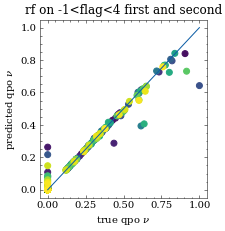

In [124]:
(x_vals, _, merged_df) =  return_x(4)
y_vals = return_y('third')
pred_freqs, true_freqs = test(x_vals, y_vals, 'rf', 'rf on -1<flag<4 first and second')

### resume with first/second qpo testing 

In [121]:
def test(x_vals, y_vals, mod:str, title:str, size:int=2): 
    
    if mod == 'rf': 
        regr = RandomForestRegressor()
    
    elif mod == 'ols': 
        regr = LinearRegression()

    else: 
        raise BaseException('wrong input type for model!')
    
    regr.fit(x_vals,y_vals)

    predictions = regr.predict(x_vals)

    if size==1: 
        predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])

        test_freqs = np.array([y_vals[i][0] for i in range(len(y_vals))])

    elif size==2: 
        predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])

        test_freqs = np.array([y_vals[i][0:2] for i in range(len(y_vals))])

    else: 
        raise BaseException('wrong size!')

    fig, ax = plt.subplots(figsize=(3,3))
    fig.tight_layout()

    colors = np.sort(size*list(range(len(predictions))))
    

    ax.scatter(test_freqs, predicted_freqs, c=colors)
    ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$', title=title)

    ax.plot([0,1], [0,1])    
    plt.show()

    return predicted_freqs, test_freqs


270 270


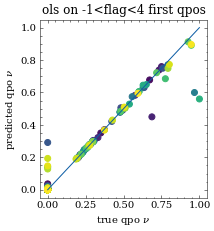

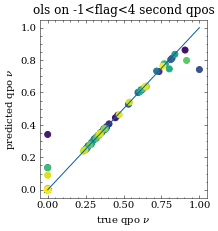

In [61]:
x_vals, full_ids = return_x(4)

print(len(return_y('first')), len(return_y('second')))
pred_freqs, true_freqs = test(x_vals, return_y('first'), 'rf', 'ols on -1<flag<4 first qpos')
_, _ =test(x_vals, return_y('second'), 'rf', 'ols on -1<flag<4 second qpos')


### investigate first qpos that are messed up but <4 in confidence class

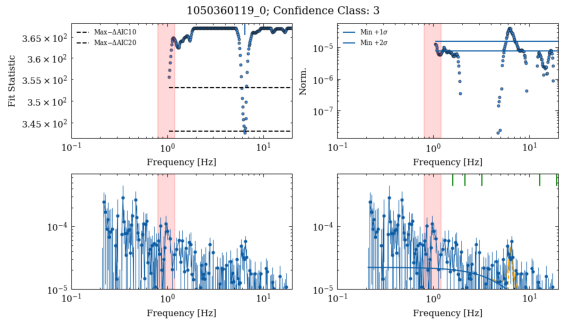

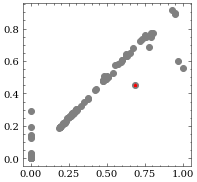

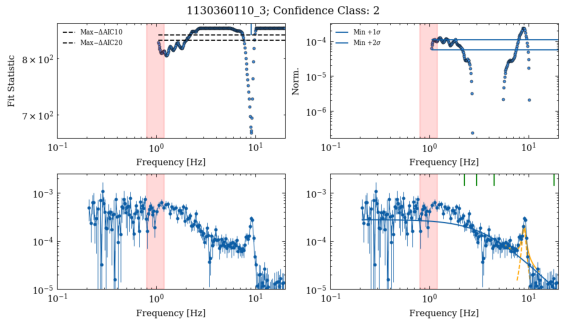

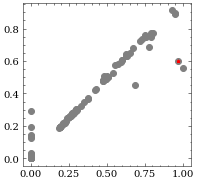

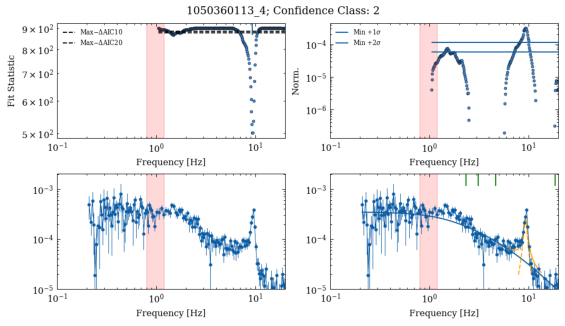

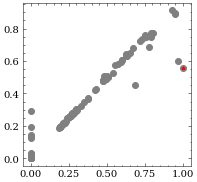

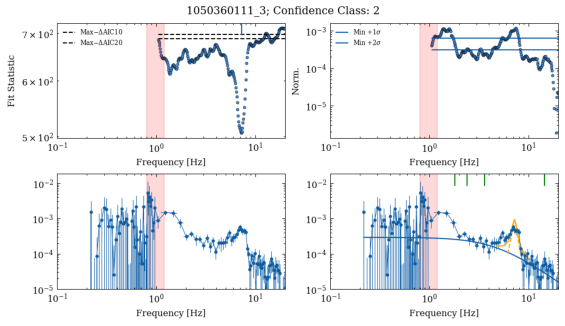

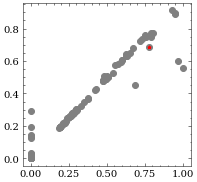

In [67]:
for i, true in enumerate(true_freqs): 
    pred = pred_freqs[i]
    id = full_ids[i]

    if true>0.25: 
        if np.abs(pred-true)>0.075: 
            fig, ax = plt.subplots(figsize=(10,7))

            ax.imshow(get_plot(id))
            ax.axis('off')
            plt.show()

            plt.clf()
            plt.close()

            fig, ax = plt.subplots(figsize=(3,3))

            ax.scatter(true_freqs, pred_freqs, color='grey')
            ax.scatter([true], [pred], color='red', s=10, marker='*')
            plt.show()
            plt.clf()
            plt.close()

### investigate messed up ones that predict qpo when there should be none

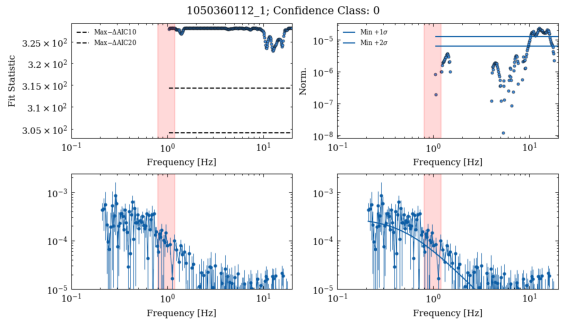

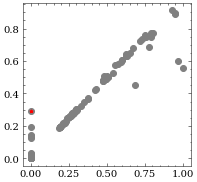

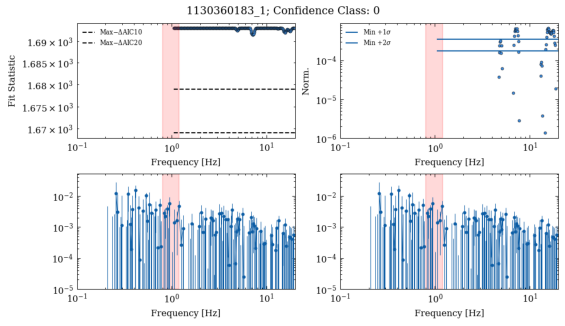

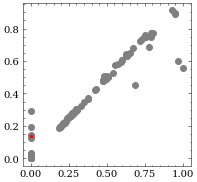

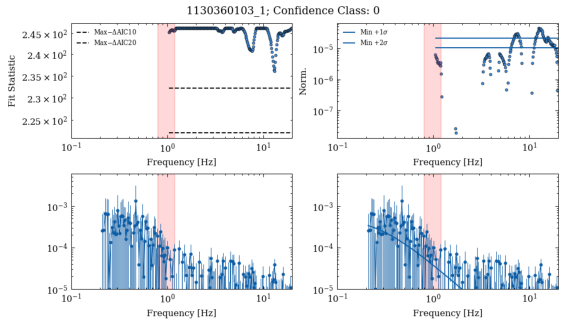

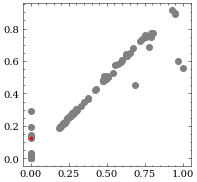

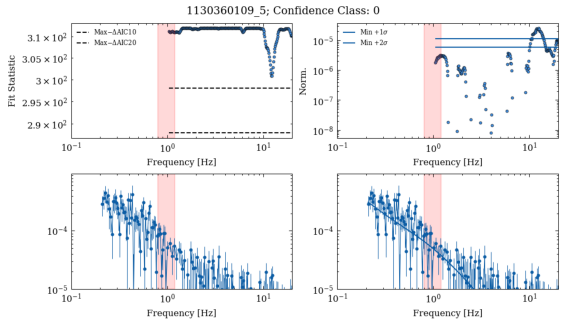

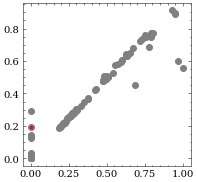

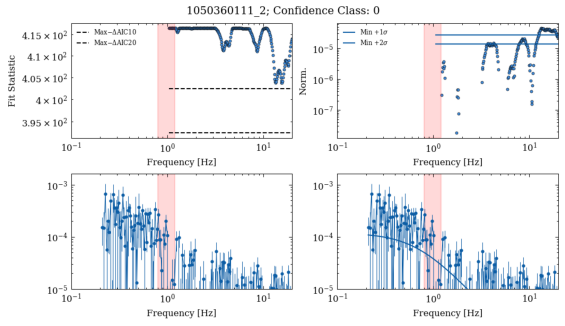

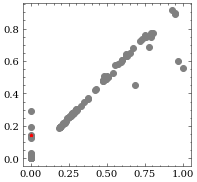

In [69]:
for i, true in enumerate(true_freqs): 
    pred = pred_freqs[i]
    id = full_ids[i]

    if true==0: 
        if np.abs(pred-true)>0.075: 
            fig, ax = plt.subplots(figsize=(10,7))

            ax.imshow(get_plot(id))
            ax.axis('off')
            plt.show()

            plt.clf()
            plt.close()

            fig, ax = plt.subplots(figsize=(3,3))

            ax.scatter(true_freqs, pred_freqs, color='grey')
            ax.scatter([true], [pred], color='red', s=10, marker='*')
            plt.show()
            plt.clf()
            plt.close()

### investigate fourth class

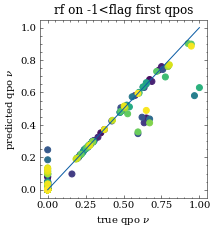

In [99]:
x_vals, full_ids = return_x(5)
pred_freqs, true_freqs = test(x_vals, return_y('first'), 'rf', 'rf on -1<flag first qpos')

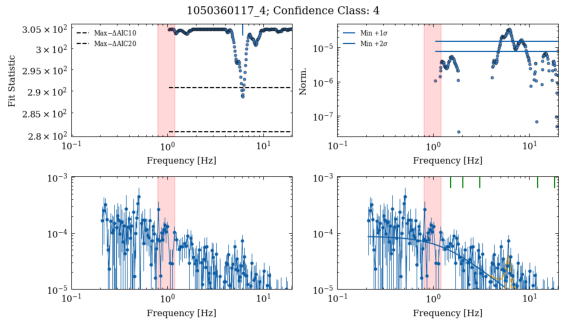

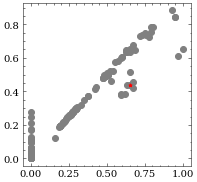

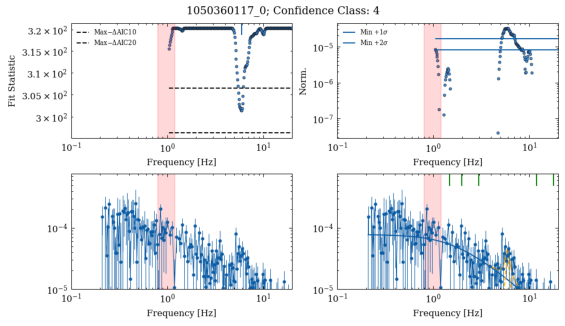

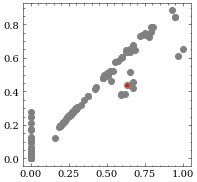

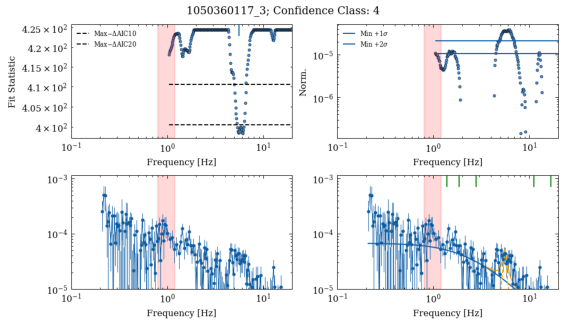

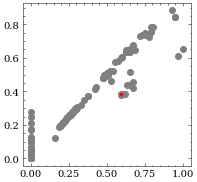

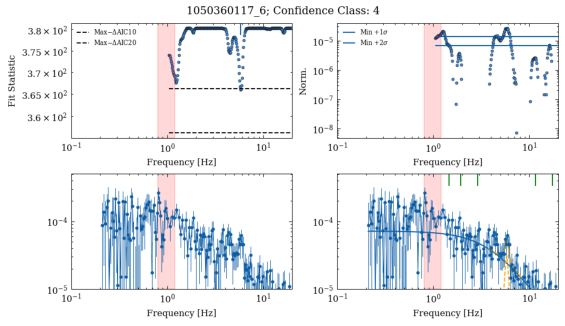

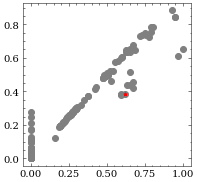

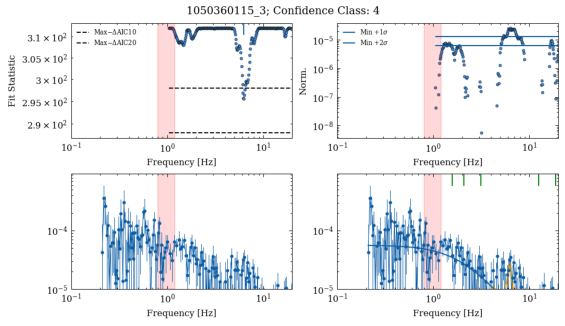

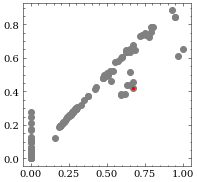

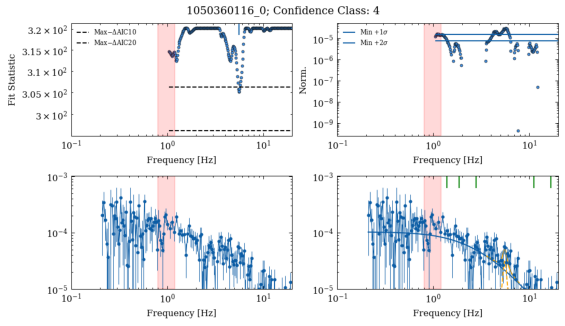

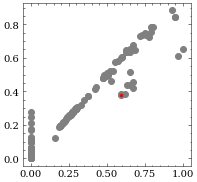

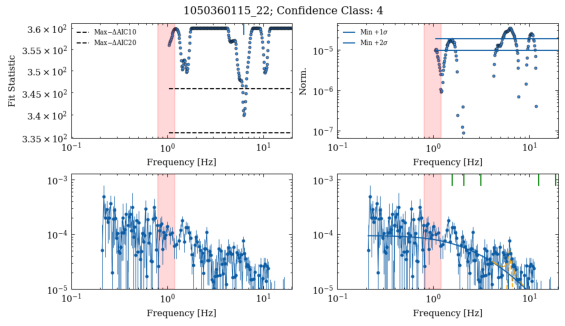

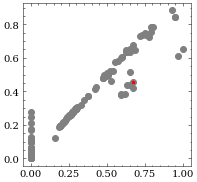

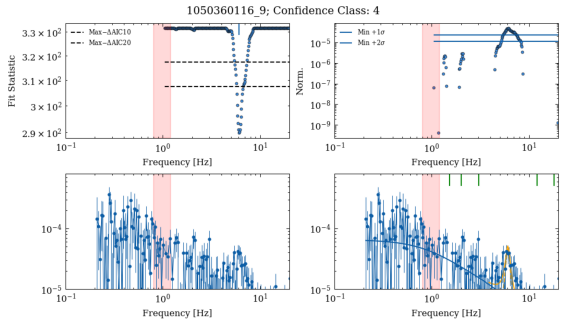

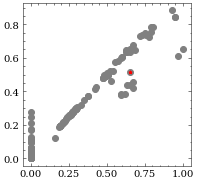

In [86]:
for i, true in enumerate(true_freqs): 
    pred = pred_freqs[i]
    id = full_ids[i]
    confidence = confidences[i]
    if confidence==4 and true>0.1: 
        if np.abs(pred-true)>0.075: 
            fig, ax = plt.subplots(figsize=(10,7))

            ax.imshow(get_plot(id))
            ax.axis('off')
            plt.show()

            plt.clf()
            plt.close()

            fig, ax = plt.subplots(figsize=(3,3))

            ax.scatter(true_freqs, pred_freqs, color='grey')
            ax.scatter([true], [pred], color='red', s=10, marker='*')
            plt.show()
            plt.clf()
            plt.close()

In [37]:
x = 4
if x%2==1: 
    print('ye')
else: 
    raise BaseException('ohhhh man')

BaseException: ohhhh man